# GroupTimeSeriesSplit: A scikit-learn compatible version of the time series validation with groups

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from mlxtend.evaluate.time_series import GroupTimeSeriesSplit

## Prepare sample data

In [3]:
months_map = {f'2021-0{i+1}': i for i in range(6)}
months_map

{'2021-01': 0,
 '2021-02': 1,
 '2021-03': 2,
 '2021-04': 3,
 '2021-05': 4,
 '2021-06': 5}

In [4]:
months = ['2021-01', '2021-02', '2021-02', '2021-02', '2021-02', '2021-03',
          '2021-03', '2021-03', '2021-04', '2021-04', '2021-05', '2021-05',
          '2021-06', '2021-06', '2021-06', '2021-06']
months

['2021-01',
 '2021-02',
 '2021-02',
 '2021-02',
 '2021-02',
 '2021-03',
 '2021-03',
 '2021-03',
 '2021-04',
 '2021-04',
 '2021-05',
 '2021-05',
 '2021-06',
 '2021-06',
 '2021-06',
 '2021-06']

In [5]:
groups = np.fromiter(map(months_map.get, months), dtype='int')
groups

array([0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5])

### Features and targets

In [6]:
data = [[0], [7], [6], [4], [4], [8], [0], [6], [2], [0], [5], [9], [7], [7], [7], [7]]
target = [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

X = pd.DataFrame(data, index=months, columns=['num_feature'])
y = pd.Series(target, name='target')

display(X, y)

,num_feature
2021-01,0
2021-02,7
2021-02,6
2021-02,4
2021-02,4
2021-03,8
2021-03,0
2021-03,6
2021-04,2
2021-04,0


0     1
1     0
2     1
3     0
4     1
5     0
6     0
7     1
8     1
9     1
10    0
11    1
12    1
13    0
14    0
15    0
Name: target, dtype: int64

## Define helper function

In [7]:
def test_cv(X, y, groups, **cv_args):
    cv = GroupTimeSeriesSplit(**cv_args)
    groups = np.array(groups)
    
    for train_idx, test_idx in cv.split(X, groups=groups):
        print('TRAIN INDICES:', train_idx)
        print('TEST INDICES:', test_idx)
        print('TRAIN LENGTH:', len(train_idx))
        print('TEST LENGTH:', len(test_idx))
        print('TRAIN GROUPS:', groups[train_idx]) 
        print('TEST GROUPS:', groups[test_idx])
        print('TRAIN GROUP SIZE:', len(set(groups[train_idx]))) 
        print('TEST GROUP SIZE:', len(set(groups[test_idx])))
        print('TRAIN GROUP MONTHS:', X.index[train_idx].values) 
        print('TEST GROUP MONTHS:', X.index[test_idx].values)
        print()

def plot_cv_indices(cv, X, y, groups, n_splits,
                    image_file_path=None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(figsize=(12, 4))
    cmap_data = plt.cm.tab20
    cmap_cv = plt.cm.coolwarm
    lw = 10
    marker_size = 200
    
    for split_idx, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y, groups=groups)):
        indices = np.array([np.nan] * len(X))
        indices[test_idx] = 1
        indices[train_idx] = 0
        
        ax.scatter(
            range(len(X)),
            [split_idx + 0.5] * len(X),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.4,
            vmax=1.4,
            s=marker_size
        )
    ax.scatter(
        range(len(X)), [split_idx + 1.5] * len(X), 
        c=groups, marker="_", lw=lw, 
        cmap=cmap_data, s=marker_size
    )

    yticklabels = list(range(n_splits)) + ['group']
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        ylabel='CV iteration',
        ylim=[n_splits + 1.2, -0.2],
        xlim=[-0.5, len(indices) - 0.5]
    )
    ax.legend(
        [Patch(color=cmap_cv(0.2)), Patch(color=cmap_cv(0.8))],
        ["Training set", "Testing set"],
        loc=(1.02, 0.8),
        fontsize=13
    )
    
    ax.set_title('{}\n{}'.format(type(cv).__name__, cv_args), fontsize=15)
    ax.xaxis.set_major_locator(MaxNLocator(min_n_ticks=len(X), integer=True))
    ax.set_xlabel(xlabel='Sample index', fontsize=13)
    ax.set_ylabel(ylabel='CV iteration', fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.tick_params(axis='both', which='minor', labelsize=13)
    
    plt.tight_layout()
    
    if image_file_path:
        plt.savefig(image_file_path, bbox_inches='tight')
        
    plt.show()
    
def plot_cv(X, y, groups, image_file_path=None, **cv_args):
    cv = GroupTimeSeriesSplit(**cv_args)
    cv._n_groups = len(np.unique(groups))
    cv._calculate_split_params()
    n_splits = cv.n_splits
    
    plot_cv_indices(cv, X, y, groups, n_splits,
                    image_file_path=image_file_path)

## Check train/test split

In [8]:
cv_args = {
    'test_size': 3, 
    'n_splits': 1
}

TRAIN INDICES: [0 1 2 3 4 5 6 7]
TEST INDICES: [ 8  9 10 11 12 13 14 15]
TRAIN LENGTH: 8
TEST LENGTH: 8
TRAIN GROUPS: [0 1 1 1 1 2 2 2]
TEST GROUPS: [3 3 4 4 5 5 5 5]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04' '2021-05' '2021-05' '2021-06' '2021-06' '2021-06'
 '2021-06']



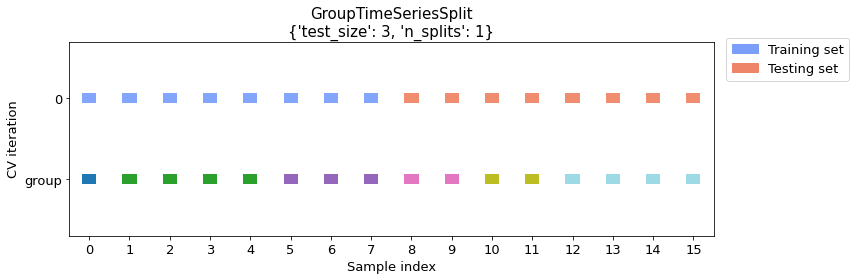

In [9]:
test_cv(X, y, groups, **cv_args)
plot_cv(X, y, groups, **cv_args)

## Check cross-validation split

### Success cases

- test_size + train_size 
- test_size + n_splits
- test_size + n_splits + gap_size
- test_size + n_splits + shift_size
- test_size + n_splits + expanding window
- test_size + train_size + n_splits (full usage of data)
- test_size + train_size + n_splits (partial usage of data)
- Groups are not sorted
- Group names
- Usage in CV

**test_size + train_size**

TRAIN INDICES: [0 1 2 3 4 5 6 7]
TEST INDICES: [8 9]
TRAIN LENGTH: 8
TEST LENGTH: 2
TRAIN GROUPS: [0 1 1 1 1 2 2 2]
TEST GROUPS: [3 3]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04']

TRAIN INDICES: [1 2 3 4 5 6 7 8 9]
TEST INDICES: [10 11]
TRAIN LENGTH: 9
TEST LENGTH: 2
TRAIN GROUPS: [1 1 1 1 2 2 2 3 3]
TEST GROUPS: [4 4]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03'
 '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05']

TRAIN INDICES: [ 5  6  7  8  9 10 11]
TEST INDICES: [12 13 14 15]
TRAIN LENGTH: 7
TEST LENGTH: 4
TRAIN GROUPS: [2 2 2 3 3 4 4]
TEST GROUPS: [5 5 5 5]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04' '2021-05' '2021-05']
TEST GROUP MONTHS: ['2021-06' '2021-06' '2021-06' '2021-06']



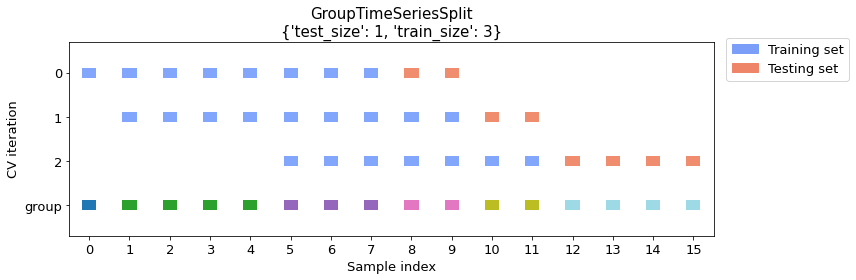

In [10]:
cv_args = {
    'test_size': 1,
    'train_size': 3
}

test_cv(X, y, groups, **cv_args)
plot_cv(X, y, groups, **cv_args)

**test_size + n_splits**

TRAIN INDICES: [0 1 2 3 4]
TEST INDICES: [5 6 7 8 9]
TRAIN LENGTH: 5
TEST LENGTH: 5
TRAIN GROUPS: [0 1 1 1 1]
TEST GROUPS: [2 2 2 3 3]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 2
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02']
TEST GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']

TRAIN INDICES: [1 2 3 4 5 6 7]
TEST INDICES: [ 8  9 10 11]
TRAIN LENGTH: 7
TEST LENGTH: 4
TRAIN GROUPS: [1 1 1 1 2 2 2]
TEST GROUPS: [3 3 4 4]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 2
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04' '2021-05' '2021-05']

TRAIN INDICES: [5 6 7 8 9]
TEST INDICES: [10 11 12 13 14 15]
TRAIN LENGTH: 5
TEST LENGTH: 6
TRAIN GROUPS: [2 2 2 3 3]
TEST GROUPS: [4 4 5 5 5 5]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 2
TRAIN GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06']



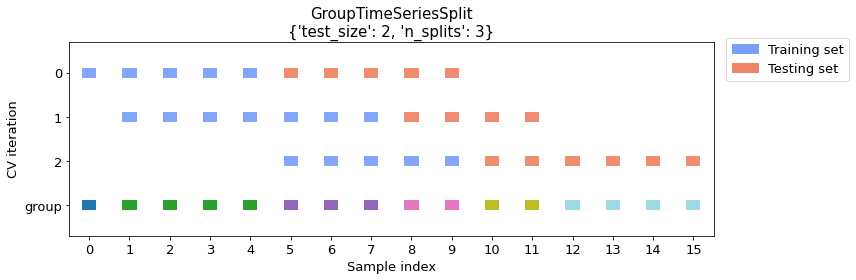

In [11]:
cv_args = {
    'test_size': 2,
    'n_splits': 3
}

test_cv(X, y, groups, **cv_args)
plot_cv(X, y, groups, **cv_args)

**test_size + n_splits + gap_size**

TRAIN INDICES: [0 1 2 3 4]
TEST INDICES: [8 9]
TRAIN LENGTH: 5
TEST LENGTH: 2
TRAIN GROUPS: [0 1 1 1 1]
TEST GROUPS: [3 3]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02']
TEST GROUP MONTHS: ['2021-04' '2021-04']

TRAIN INDICES: [1 2 3 4 5 6 7]
TEST INDICES: [10 11]
TRAIN LENGTH: 7
TEST LENGTH: 2
TRAIN GROUPS: [1 1 1 1 2 2 2]
TEST GROUPS: [4 4]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03']
TEST GROUP MONTHS: ['2021-05' '2021-05']

TRAIN INDICES: [5 6 7 8 9]
TEST INDICES: [12 13 14 15]
TRAIN LENGTH: 5
TEST LENGTH: 4
TRAIN GROUPS: [2 2 2 3 3]
TEST GROUPS: [5 5 5 5]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-06' '2021-06' '2021-06' '2021-06']



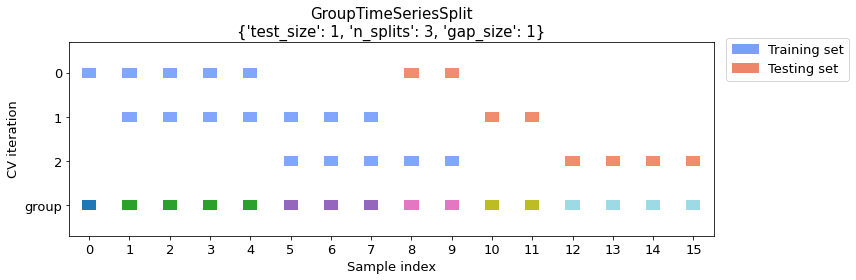

In [12]:
cv_args = {
    'test_size': 1,
    'n_splits': 3,
    'gap_size': 1
}

test_cv(X, y, groups, **cv_args)
plot_cv(X, y, groups, **cv_args)

**test_size + n_splits + shift_size**

TRAIN INDICES: [0 1 2 3 4 5 6 7]
TEST INDICES: [8 9]
TRAIN LENGTH: 8
TEST LENGTH: 2
TRAIN GROUPS: [0 1 1 1 1 2 2 2]
TEST GROUPS: [3 3]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04']

TRAIN INDICES: [ 5  6  7  8  9 10 11]
TEST INDICES: [12 13 14 15]
TRAIN LENGTH: 7
TEST LENGTH: 4
TRAIN GROUPS: [2 2 2 3 3 4 4]
TEST GROUPS: [5 5 5 5]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04' '2021-05' '2021-05']
TEST GROUP MONTHS: ['2021-06' '2021-06' '2021-06' '2021-06']



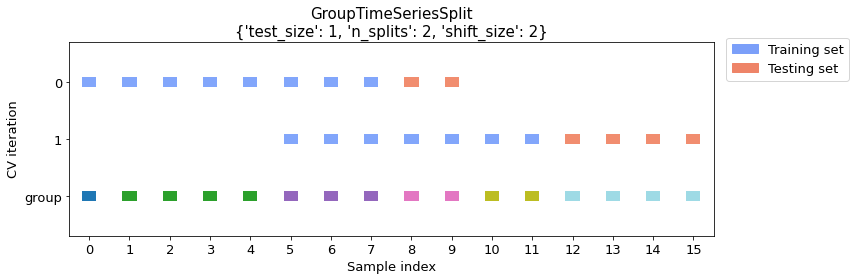

In [13]:
cv_args = {
    'test_size': 1,
    'n_splits': 2,
    'shift_size': 2
}

test_cv(X, y, groups, **cv_args)
plot_cv(X, y, groups, **cv_args)

**test_size + n_splits + expanding window**

TRAIN INDICES: [0]
TEST INDICES: [1 2 3 4 5 6 7 8 9]
TRAIN LENGTH: 1
TEST LENGTH: 9
TRAIN GROUPS: [0]
TEST GROUPS: [1 1 1 1 2 2 2 3 3]
TRAIN GROUP SIZE: 1
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01']
TEST GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03'
 '2021-04' '2021-04']

TRAIN INDICES: [0 1 2 3 4]
TEST INDICES: [ 5  6  7  8  9 10 11]
TRAIN LENGTH: 5
TEST LENGTH: 7
TRAIN GROUPS: [0 1 1 1 1]
TEST GROUPS: [2 2 2 3 3 4 4]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02']
TEST GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04' '2021-05' '2021-05']

TRAIN INDICES: [0 1 2 3 4 5 6 7]
TEST INDICES: [ 8  9 10 11 12 13 14 15]
TRAIN LENGTH: 8
TEST LENGTH: 8
TRAIN GROUPS: [0 1 1 1 1 2 2 2]
TEST GROUPS: [3 3 4 4 5 5 5 5]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
TEST GROUP MONTHS: 

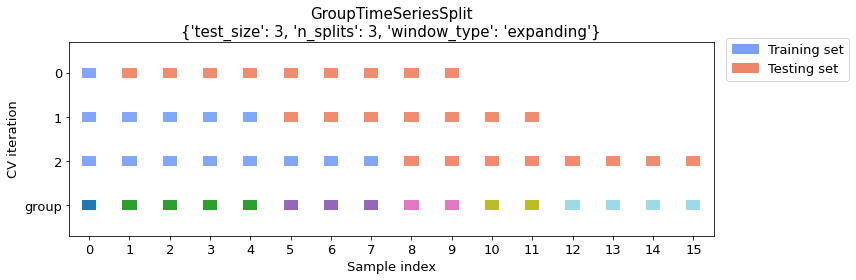

In [14]:
cv_args = {
    'test_size': 3,
    'n_splits': 3,
    'window_type': 'expanding'
}

test_cv(X, y, groups, **cv_args)
plot_cv(X, y, groups, **cv_args)

**test_size + train_size + n_splits (full usage of data)**

TRAIN INDICES: [0 1 2 3 4]
TEST INDICES: [ 5  6  7  8  9 10 11]
TRAIN LENGTH: 5
TEST LENGTH: 7
TRAIN GROUPS: [0 1 1 1 1]
TEST GROUPS: [2 2 2 3 3 4 4]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02']
TEST GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04' '2021-05' '2021-05']

TRAIN INDICES: [1 2 3 4 5 6 7]
TEST INDICES: [ 8  9 10 11 12 13 14 15]
TRAIN LENGTH: 7
TEST LENGTH: 8
TRAIN GROUPS: [1 1 1 1 2 2 2]
TEST GROUPS: [3 3 4 4 5 5 5 5]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 3
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04' '2021-05' '2021-05' '2021-06' '2021-06' '2021-06'
 '2021-06']



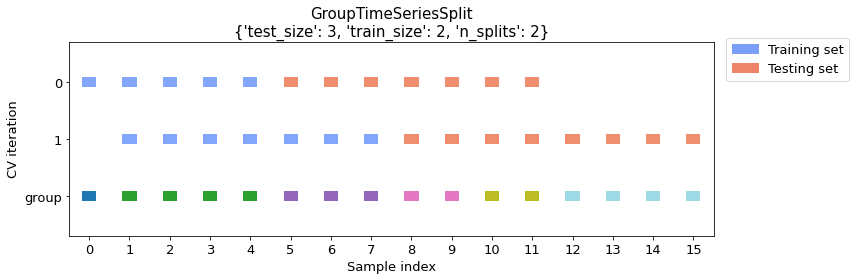

In [15]:
cv_args = {
    'test_size': 3,
    'train_size': 2,
    'n_splits': 2
}

test_cv(X, y, groups, **cv_args)
plot_cv(X, y, groups, **cv_args)

**test_size + train_size + n_splits (partial usage of data)**

TRAIN INDICES: [1 2 3 4 5 6 7]
TEST INDICES: [ 8  9 10 11]
TRAIN LENGTH: 7
TEST LENGTH: 4
TRAIN GROUPS: [1 1 1 1 2 2 2]
TEST GROUPS: [3 3 4 4]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 2
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04' '2021-05' '2021-05']

TRAIN INDICES: [5 6 7 8 9]
TEST INDICES: [10 11 12 13 14 15]
TRAIN LENGTH: 5
TEST LENGTH: 6
TRAIN GROUPS: [2 2 2 3 3]
TEST GROUPS: [4 4 5 5 5 5]
TRAIN GROUP SIZE: 2
TEST GROUP SIZE: 2
TRAIN GROUP MONTHS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05' '2021-06' '2021-06' '2021-06' '2021-06']



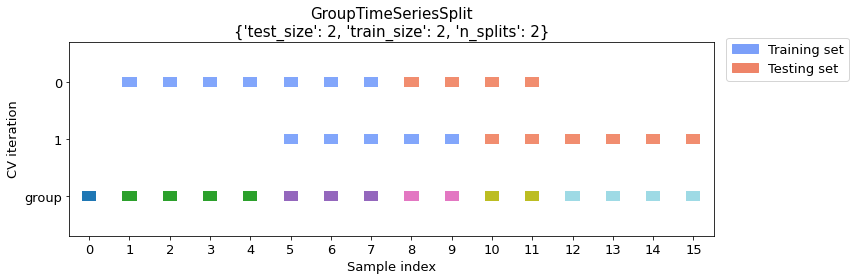

In [16]:
cv_args = {
    'test_size': 2,
    'train_size': 2,
    'n_splits': 2
}

test_cv(X, y, groups, **cv_args)
plot_cv(X, y, groups, **cv_args)

**Groups are not sorted**

In [17]:
not_sorted_months = ['2021-06', '2021-06', '2021-06', '2021-06', '2021-02', '2021-02', 
                     '2021-02', '2021-02', '2021-04', '2021-04', '2021-03', '2021-03', 
                     '2021-03', '2021-05', '2021-05', '2021-01']
not_sorted_months

['2021-06',
 '2021-06',
 '2021-06',
 '2021-06',
 '2021-02',
 '2021-02',
 '2021-02',
 '2021-02',
 '2021-04',
 '2021-04',
 '2021-03',
 '2021-03',
 '2021-03',
 '2021-05',
 '2021-05',
 '2021-01']

In [18]:
not_sorted_groups = np.fromiter(map(months_map.get, not_sorted_months), dtype='int')
not_sorted_groups

array([5, 5, 5, 5, 1, 1, 1, 1, 3, 3, 2, 2, 2, 4, 4, 0])

In [19]:
X_not_sorted = X.copy()
X_not_sorted.index = not_sorted_months
X_not_sorted

,num_feature
2021-06,0
2021-06,7
2021-06,6
2021-06,4
2021-02,4
2021-02,8
2021-02,0
2021-02,6
2021-04,2
2021-04,0


TRAIN INDICES: [0 1 2 3 4 5 6 7 8 9]
TEST INDICES: [10 11 12]
TRAIN LENGTH: 10
TEST LENGTH: 3
TRAIN GROUPS: [5 5 5 5 1 1 1 1 3 3]
TEST GROUPS: [2 2 2]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-06' '2021-06' '2021-06' '2021-06' '2021-02' '2021-02' '2021-02'
 '2021-02' '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-03' '2021-03' '2021-03']

TRAIN INDICES: [ 4  5  6  7  8  9 10 11 12]
TEST INDICES: [13 14]
TRAIN LENGTH: 9
TEST LENGTH: 2
TRAIN GROUPS: [1 1 1 1 3 3 2 2 2]
TEST GROUPS: [4 4]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-04' '2021-04' '2021-03'
 '2021-03' '2021-03']
TEST GROUP MONTHS: ['2021-05' '2021-05']

TRAIN INDICES: [ 8  9 10 11 12 13 14]
TEST INDICES: [15]
TRAIN LENGTH: 7
TEST LENGTH: 1
TRAIN GROUPS: [3 3 2 2 2 4 4]
TEST GROUPS: [0]
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-04' '2021-04' '2021-03' '2021-03' '2021-03' '2021-05' '2021-05']
TEST GROUP MONTHS: ['2021

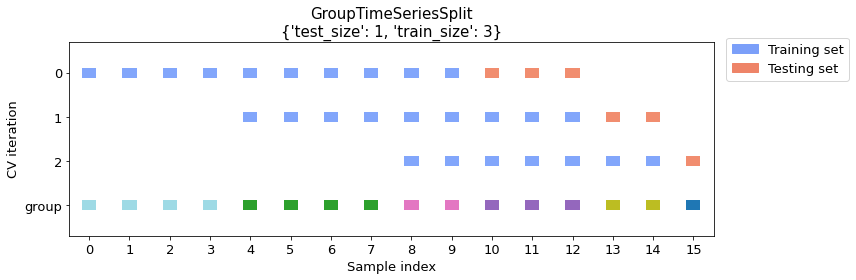

In [20]:
cv_args = {
    'test_size': 1,
    'train_size': 3
}

test_cv(X_not_sorted, y, not_sorted_groups, **cv_args)
plot_cv(X_not_sorted, y, not_sorted_groups, **cv_args)

**Group names**

In [21]:
cv_args = {
    'test_size': 1,
    'train_size': 3
}

test_cv(X, y, months, **cv_args)

TRAIN INDICES: [0 1 2 3 4 5 6 7]
TEST INDICES: [8 9]
TRAIN LENGTH: 8
TEST LENGTH: 2
TRAIN GROUPS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
TEST GROUPS: ['2021-04' '2021-04']
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-01' '2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03'
 '2021-03']
TEST GROUP MONTHS: ['2021-04' '2021-04']

TRAIN INDICES: [1 2 3 4 5 6 7 8 9]
TEST INDICES: [10 11]
TRAIN LENGTH: 9
TEST LENGTH: 2
TRAIN GROUPS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03'
 '2021-04' '2021-04']
TEST GROUPS: ['2021-05' '2021-05']
TRAIN GROUP SIZE: 3
TEST GROUP SIZE: 1
TRAIN GROUP MONTHS: ['2021-02' '2021-02' '2021-02' '2021-02' '2021-03' '2021-03' '2021-03'
 '2021-04' '2021-04']
TEST GROUP MONTHS: ['2021-05' '2021-05']

TRAIN INDICES: [ 5  6  7  8  9 10 11]
TEST INDICES: [12 13 14 15]
TRAIN LENGTH: 7
TEST LENGTH: 4
TRAIN GROUPS: ['2021-03' '2021-03' '2021-03' '2021-04' '2021-04' '2021-05' '202

## Usage in CV

In [22]:
cv_args = {
    'test_size': 1,
    'train_size': 3
}
cv = GroupTimeSeriesSplit(**cv_args)
clf = DummyClassifier(strategy='most_frequent')

scores = cross_val_score(clf, X, y, groups=groups, scoring='accuracy', cv=cv)
scores

array([0.  , 0.5 , 0.25])

In [23]:
clf = DummyClassifier(strategy='most_frequent')

for train_idx, test_idx in cv.split(X, y, groups):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_train_pred = clf.predict(X.iloc[train_idx])
    y_test_pred = clf.predict(X.iloc[test_idx])
    print(y.iloc[train_idx].values, y_train_pred,
          y.iloc[test_idx].values, y_test_pred)

[1 0 1 0 1 0 0 1] [0 0 0 0 0 0 0 0] [1 1] [0 0]
[0 1 0 1 0 0 1 1 1] [1 1 1 1 1 1 1 1 1] [0 1] [1 1]
[0 0 1 1 1 0 1] [1 1 1 1 1 1 1] [1 0 0 0] [1 1 1 1]


### Failed cases

- Groups are not consecutive
- Both train_size and n_splits are specified
- Incorrect window name
- Specify train_size with expanding window
- Not enough data (too many number of splits)
- Not enough data (too large value of shift size)
- Not enough data (too large value of gap size)

**Groups are not consecutive**

In [24]:
not_consecutive_months = ['2021-01', '2021-02', '2021-02', '2021-02', '2021-02', '2021-03',
                          '2021-03', '2021-03', '2021-04', '2021-04', '2021-05', '2021-05',
                          '2021-03', '2021-03', '2021-03', '2021-03']
not_consecutive_months

['2021-01',
 '2021-02',
 '2021-02',
 '2021-02',
 '2021-02',
 '2021-03',
 '2021-03',
 '2021-03',
 '2021-04',
 '2021-04',
 '2021-05',
 '2021-05',
 '2021-03',
 '2021-03',
 '2021-03',
 '2021-03']

In [25]:
not_consecutive_groups = np.fromiter(map(months_map.get, not_consecutive_months), dtype='int')
not_consecutive_groups

array([0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 2, 2, 2, 2])

In [26]:
try:
    test_cv(X, y, not_consecutive_groups, **cv_args)
except ValueError as e:
    print(e)

The groups should be consecutive


**Both train_size and n_splits are not specified**

In [27]:
cv_args = {
    'test_size': 3
}

try:
    test_cv(X, y, groups, **cv_args)
except ValueError as e:
    print(e)

Either train_size or n_splits should be defined


**Incorrect window name**

In [28]:
cv_args = {
    'test_size': 3,
    'n_splits': 3,
    'window_type': 'bad_name'
}

try:
    test_cv(X, y, groups, **cv_args)
except ValueError as e:
    print(e)

Window type can be either "rolling" or "expanding"


**Specify train_size with expanding window**

In [29]:
cv_args = {
    'test_size': 3,
    'train_size': 3,
    'window_type': 'expanding'
}

try:
    test_cv(X, y, groups, **cv_args)
except ValueError as e:
    print(e)

Train size can be specified only with rolling window


**Not enough data (too large train_size and/or n_splits)**

In [30]:
cv_args = {
    'test_size': 1,
    'train_size': 10, 
    'n_splits': 10
}

try:
    test_cv(X, y, groups, **cv_args)
except ValueError as e:
    print(e)

Not enough data to split number of groups (6) for number splits (10) with train size (10), test size (1), gap size (0), shift size (1)


**Not enough data (too many number of splits)**

In [31]:
cv_args = {
    'test_size': 1,
    'n_splits': 10
}

try:
    test_cv(X, y, groups, **cv_args)
except ValueError as e:
    print(e)

Not enough data to split number of groups (6) for number splits (10) with train size (-4), test size (1), gap size (0), shift size (1)


**Not enough data (too large values of shift size)**

In [32]:
cv_args = {
    'test_size': 1,
    'n_splits': 3,
    'shift_size': 10
}

try:
    test_cv(X, y, groups, **cv_args)
except ValueError as e:
    print(e)

Not enough data to split number of groups (6) for number splits (3) with train size (-15), test size (1), gap size (0), shift size (10)


**Not enough data (too large values of gap size)**

In [33]:
cv_args = {
    'test_size': 1,
    'n_splits': 3,
    'gap_size': 10
}

try:
    test_cv(X, y, groups, **cv_args)
except ValueError as e:
    print(e)

Not enough data to split number of groups (6) for number splits (3) with train size (-7), test size (1), gap size (10), shift size (1)
